![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_CAMS.png)

# Global Air Quality Index

**Run the tutorial via free cloud platforms**: [![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/2024-cams-act6-training/main?labpath=08-aqi/cams_glob_eaqi.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/2024-cams-act6-training/blob/main/08-aqi/cams_glob_eaqi.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/2024-cams-act6-training/blob/main/08-aqi/cams_glob_eaqi.ipynb)

## Learning objectives

In this notebook we'll compute the forecasts of the global air quality index (AQI). The computation of the AQI forecast is based on the forecast concentration of the following pollutants: $O_3, NO_2, SO_2, PM2.5, PM10$. The index is computed according to the [European Air Quality Index](https://en.wikipedia.org/wiki/Air_quality_index#Europe) definition. The concentration of the pollutants will be time averaged and transformed in $\mu g \cdot m^{-3}$ and finally classified in one of six levels, from *Good* to *Extremly poor*, according to the threshold levels defined in the European Air Quality Index. The air quality index is the highest value of the concentration levels of the pollutants. For instance, if the concentration level in a grid cell for $NO_2, SO_2, PM2.5, PM10$ is *Good* but for $O_3$ is *Mediocre*, then the air quality index for that grid cell is *Mediocre*. 

## Initial setup

Before we begin we must prepare our computing environment. This includes installing the client software of the Application Programming Interface (API) of the Climate Data Store (CDS), intalling all the packages required to execute the code, setting up our CDS API credentials and importing the various Python libraries that will be used. If you are executing this notebook on your laptop it is assumed that you have created a conda environment with all the packages installed as specified in the *environment.yml* file in the root folder of the repository. On the other hand, if you are using a cloud environment, such as Google Colab, you will have to uncomment the following cell to install those packages since they are not provided by default. 

In [9]:
# If you are running this notebook in Colab, ensure that the cdsapi package is installed
#!pip install -q cdsapi

In [10]:
# If you are running this notebook in Colab, uncomment the line below and run this cell.
#!pip install cartopy

In [11]:
# If you are running this notebook in Colab, uncomment the line below and run this cell
#!pip install xarray==2024.7.0

### Add your ADS API credentials

To set up your ADS API credentials, please login/register on the [ADS](https://ads.atmosphere.copernicus.eu/), then you will see your unique API key in your [profile](https://ads.atmosphere.copernicus.eu/profile). 

You can copy your API key to your current session by replacing `#########` in the code cell below

In [61]:
import os
os.environ['CDSAPI_URL'] = 'https://ads.atmosphere.copernicus.eu/api'
os.environ['CDSAPI_KEY'] = '###########################################'

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from zipfile import ZipFile
import cdsapi
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print('Python version: %s'%python_version())
print('NumPy version: %s'%np.version.version)
print('Pandas version: %s'%pd.__version__)
print('Xarray version: %s'%xr.__version__)
print('Matplotlib version: %s'%matplotlib.__version__)
print('Cartopy version: %s'%cartopy.__version__)
print('Seaborn version: %s'%sns.__version__)

Python version: 3.12.5
NumPy version: 2.0.2
Pandas version: 2.2.2
Xarray version: 2024.7.0
Matplotlib version: 3.9.2
Cartopy version: 0.23.0
Seaborn version: 0.13.2


Here we specify a data directory in which we will download our data and all output files that we will generate:

In [2]:
DATADIR = '.'

## Explore and download data
We use the [CAMS global atmospheric composition forecasts](https://ads.atmosphere.copernicus.eu/datasets/cams-global-atmospheric-composition-forecasts) dataset. The spatial resolution is lower than that available for the [CAMS European air quality forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) used in the previous edition of the training event but it covers the whole planet. The dataset is available from the Copernicus Atmosphere Monitoring Service (CAMS). The spatial grid is 0.4° x 0.4° so that each cell has size 44 km x 44 km, approximately.  In order to compute the air quality index for each grid cell we will download the data of the pollutants and the meteorological data: surface pressure, and 2m air temperature. The trace gases are provided for 137 vertical levels and are available at 3-hours intervals. We will download the trace gases data only for the surface level, that is level 137. The particulate matter and the meteorological data are available at a single level (surface) at hourly intervals.

* Ozone mass mixing ratio [kg kg**-1]
* Sulphur dioxide mass mixing ratio [kg kg**-1]
* Nitrogen dioxide mass mixing ratio [kg kg**-1]
* Particulate matter d <= 2.5 um [kg m**-3]
* Particulate matter d <= 10 um [kg m**-3]

* Surface pressure [Pa]
* 2m air temperature [K]

The concentration of the trace gases is given using a dimensionless unit. Since we want to use a common unit for all the pollutants we will have to transform the trace gases data from a dimensionless unit to mass concentration. We will use the surface pressure and the air temperature to perform such transformation. We will request the forecast data for 96 hours, 4 days, starting from the current day at time 00:00

## Manual download
The Copernicus Atmosphere Monitoring Service provides a user interface to select the dataset and the variables of interest and download the data from their website, in addition to the APIs. This option is useful in order to have an understanging of what variables are included in a dataset and how to build a request. The web page allows a user to copy the code to submit a request using the APIs. We can visit the [download form for the CAMS global forecast data](https://ads.atmosphere.copernicus.eu/datasets/cams-global-atmospheric-composition-forecasts?tab=download) and select the variables of interest. We select in the "Single level" panel

* 2m temperature
* surface pressure
* Particulate matter d < 2.5 µm (PM2.5)
* Particulate matter d < 10 µm (PM10)

In the "Multi level" panel, we select

* Nitrogen dioxide
* Ozone
* Sulphur dioxide

In the "Model level" panel we select 137 (ground level)

For the date, we may select the current date for both start and end date. For the "Time", that is the hour of the beginning of the forecasts we may select 00:00.

In the "Leadtime hour" panel we can flag all the check boxes from 0 to 95 for a 4 days forecast.

At the end of the download form, select **Show API request**. This will reveal a block of code, which contains the same settings as the code cells for the APIs download that we will use in the API download.

**Please remember to accept the terms and conditions at the bottom of the download form.**


You might want to have a look at the content of the dataset using a NetCDF visualization tool such as [Panoply](https://www.giss.nasa.gov/tools/panoply/)  

![global O3](img/panoply.jpg)

## API download
Once we have a better knowledge of the dataset, which names are used for our variables of interest, and the forecast days and times, we can set up a request to be sent through the CDS APIs 

In [3]:
start_date = '2024-10-03'
end_date = '2024-10-03'
init_hour = '00'
lead_time_start = 0
lead_time_stop = 96
step_hours = 1
leadtime_hours = list(range(lead_time_start, lead_time_stop + lead_time_start, step_hours))

In [4]:
variables = ['2m_temperature',
            'surface_pressure', 
            'particulate_matter_2.5um',
            'particulate_matter_10um',
            'nitrogen_dioxide', 
            'ozone',
            'sulphur_dioxide']
bb_north = 90
bb_south = -90
bb_west = -180
bb_east = 180
area = [bb_north, bb_west, bb_south, bb_east]  

In [5]:
dataset = 'cams-global-atmospheric-composition-forecasts'

In [6]:
request = {
        'variable': variables,
		'date': f'{start_date}/{end_date}',
        'time': f'{init_hour}:00',
        'leadtime_hour': leadtime_hours,
        'model_level': '137',
        'type': 'forecast',
        'area': area,
        'format': 'netcdf_zip'
    }

In [23]:
c = cdsapi.Client()
c.retrieve(
    dataset,
    request,
    f'{DATADIR}/download.zip')

2024-10-04 09:51:16,228 WARNING [2024-10-04T07:51:15.581596] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2024-10-04 09:51:16,229 INFO Request ID is 09f66ddd-7a47-466a-ae5f-a7857662a3d8
2024-10-04 09:51:16,268 INFO status has been updated to accepted
2024-10-04 09:51:17,804 INFO status has been updated to running
2024-10-04 09:52:30,516 INFO status has been updated to successful


4535a01fa121a5b8277afd7d99112c55.zip:   0%|          | 0.00/379M [00:00<?, ?B/s]

'./download.zip'

We open the zip file to extract the NetCDF data files. Trace gases concentrations are in the multi-level variable file data_mlev.nc. The particulate matter concentrations and the meteorological variables, 2m air temperature and surface pressure, are in the single level variables file data_sfc.nc.

In [24]:
with ZipFile(f'{DATADIR}/download.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/')

We can remove the zip file

In [25]:
os.remove(f'{DATADIR}/download.zip')

## Aerosols and meteorological data
The concentration of aerosol PM2.5 and PM10 are provided as densities in $kg \cdot m^{-3}$, the 2m air temperature in Kelvin, the surface pressure in Pascal. 

In [7]:
single_level_ds = xr.open_dataset(f'{DATADIR}/data_sfc.nc') 
single_level_ds

<xarray.Dataset> Size: 623MB
Dimensions:                  (forecast_period: 96, forecast_reference_time: 1,
                              latitude: 451, longitude: 900)
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 768B 00:00:00 ...
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 8B 2024...
  * latitude                 (latitude) float64 4kB 90.0 89.6 ... -89.6 -90.0
  * longitude                (longitude) float64 7kB -180.0 -179.6 ... 179.6
    valid_time               (forecast_reference_time, forecast_period) datetime64[ns] 768B ...
Data variables:
    t2m                      (forecast_period, forecast_reference_time, latitude, longitude) float32 156MB ...
    sp                       (forecast_period, forecast_reference_time, latitude, longitude) float32 156MB ...
    pm2p5                    (forecast_period, forecast_reference_time, latitude, longitude) float32 156MB ...
    pm10                     (forecast_period, forecast_reference_time, latitude, longitude) float32 156MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-04T07:51 GRIB to CDM+CF via cfgrib-0.9.1...

## Trace gases
The concentration of the trace gases is provided as mixing ratio, a dimensionless quantity that represents the ratio between the mass concentration of the trace gas, in kg per unit volume, and the mass concentration of air.  

In [8]:
multi_level_ds = xr.open_dataset(f'{DATADIR}/data_mlev.nc') 
multi_level_ds

<xarray.Dataset> Size: 156MB
Dimensions:                  (forecast_period: 32, forecast_reference_time: 1,
                              model_level: 1, latitude: 451, longitude: 900)
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 256B 00:00:00 ...
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 8B 2024...
  * model_level              (model_level) float64 8B 137.0
  * latitude                 (latitude) float64 4kB 90.0 89.6 ... -89.6 -90.0
  * longitude                (longitude) float64 7kB -180.0 -179.6 ... 179.6
    valid_time               (forecast_reference_time, forecast_period) datetime64[ns] 256B ...
Data variables:
    no2                      (forecast_period, forecast_reference_time, model_level, latitude, longitude) float32 52MB ...
    go3                      (forecast_period, forecast_reference_time, model_level, latitude, longitude) float32 52MB ...
    so2                      (forecast_period, forecast_reference_time, model_level, latitude, longitude) float32 52MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-04T07:51 GRIB to CDM+CF via cfgrib-0.9.1...

## Unit transformation
We calculate the scaling factor to convert the dimensionless mixing ratios of $NO_2, SO_2$, and $O_3$ from kg/kg to mass density in ug/m3, using the air surface pressure and the temperature. The scaling factor c is defined as

$$c = \frac{p}{R_aT}$$

where $R_a$ is the gas constant of dry air, p the pressure and T the temperature. The derivation of the scalar factor is provided in the appendix.

In [9]:
R = 287.08
cfactor = single_level_ds['sp'] / (R * single_level_ds['t2m'])

With the scaling factor we can transform the concentration values of the trace gases into $kg \cdot m^{-3}$, the same unit used for the particulate matter. Then, we multiply for $10^9$ to represent the values in $\mu g \cdot m^{-3}$

In [10]:
trace_gases = ['no2','go3','so2']
for gas in trace_gases:
    multi_level_ds[gas] = multi_level_ds[gas] * cfactor * 1e9

In [11]:
particulate_matter = ['pm2p5','pm10']
for param in particulate_matter:
    single_level_ds[param] = single_level_ds[param] * 1e9

## 24h max and mean average
We aggregate the data by computing the maximun daily values of the trace gases concentration and mean daily values of the particulate matter concentration.

In [12]:
multi_level_max = multi_level_ds.resample(valid_time='1D').max()
multi_level_max = multi_level_max.squeeze(drop=True)

In [13]:
single_level_mean = single_level_ds.resample(valid_time='1D').mean()
single_level_mean = single_level_mean.squeeze(drop=True)

We merge the trace gases and the particulate matter into one multi-dimensional array

In [14]:
eaqi_daily = xr.merge([single_level_mean, multi_level_max])

In [15]:
eaqi_daily = eaqi_daily.drop_vars(["t2m", "sp"])

In [16]:
eaqi_daily

<xarray.Dataset> Size: 32MB
Dimensions:     (valid_time: 4, latitude: 451, longitude: 900)
Coordinates:
  * latitude    (latitude) float64 4kB 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude   (longitude) float64 7kB -180.0 -179.6 -179.2 ... 179.2 179.6
  * valid_time  (valid_time) datetime64[ns] 32B 2024-10-03 ... 2024-10-06
Data variables:
    pm2p5       (valid_time, latitude, longitude) float32 6MB 0.424 ... 0.0391
    pm10        (valid_time, latitude, longitude) float32 6MB 0.7998 ... 0.05665
    no2         (valid_time, latitude, longitude) float32 6MB 0.02572 ... 0.0...
    go3         (valid_time, latitude, longitude) float32 6MB 62.84 ... 47.74
    so2         (valid_time, latitude, longitude) float32 6MB 0.02272 ... 0.0...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-04T07:51 GRIB to CDM+CF via cfgrib-0.9.1...

## Plotting the global concentrations forecasts of trace gases and particulate matter
We plot the forecasts for the concentrations of the five pollutants for one day. We can plot any of the other forecast day by simply changing its day index (from 0 to 3) 

In [29]:
params = ['no2','go3','so2','pm2p5','pm10']

We define the levels of the pollutants to be plotted in order to map the values within each interval using a predefined colormap. We use different levels for each pollutant according to the concentration levels defined for the European Air Quality Index.

In [30]:
no2_limits = [0, 40, 90, 120, 230, 340, 1000]
o3_limits = [0, 50, 100, 130, 240, 380, 800]
so2_limits = [0, 100, 200, 350, 500, 750, 1250]
pm25_limits = [0, 10, 20, 25, 50, 75, 800]
pm10_limits = [0, 20, 40, 50, 100, 150, 1200]

all_levels = [no2_limits, o3_limits, so2_limits, pm25_limits, pm10_limits]

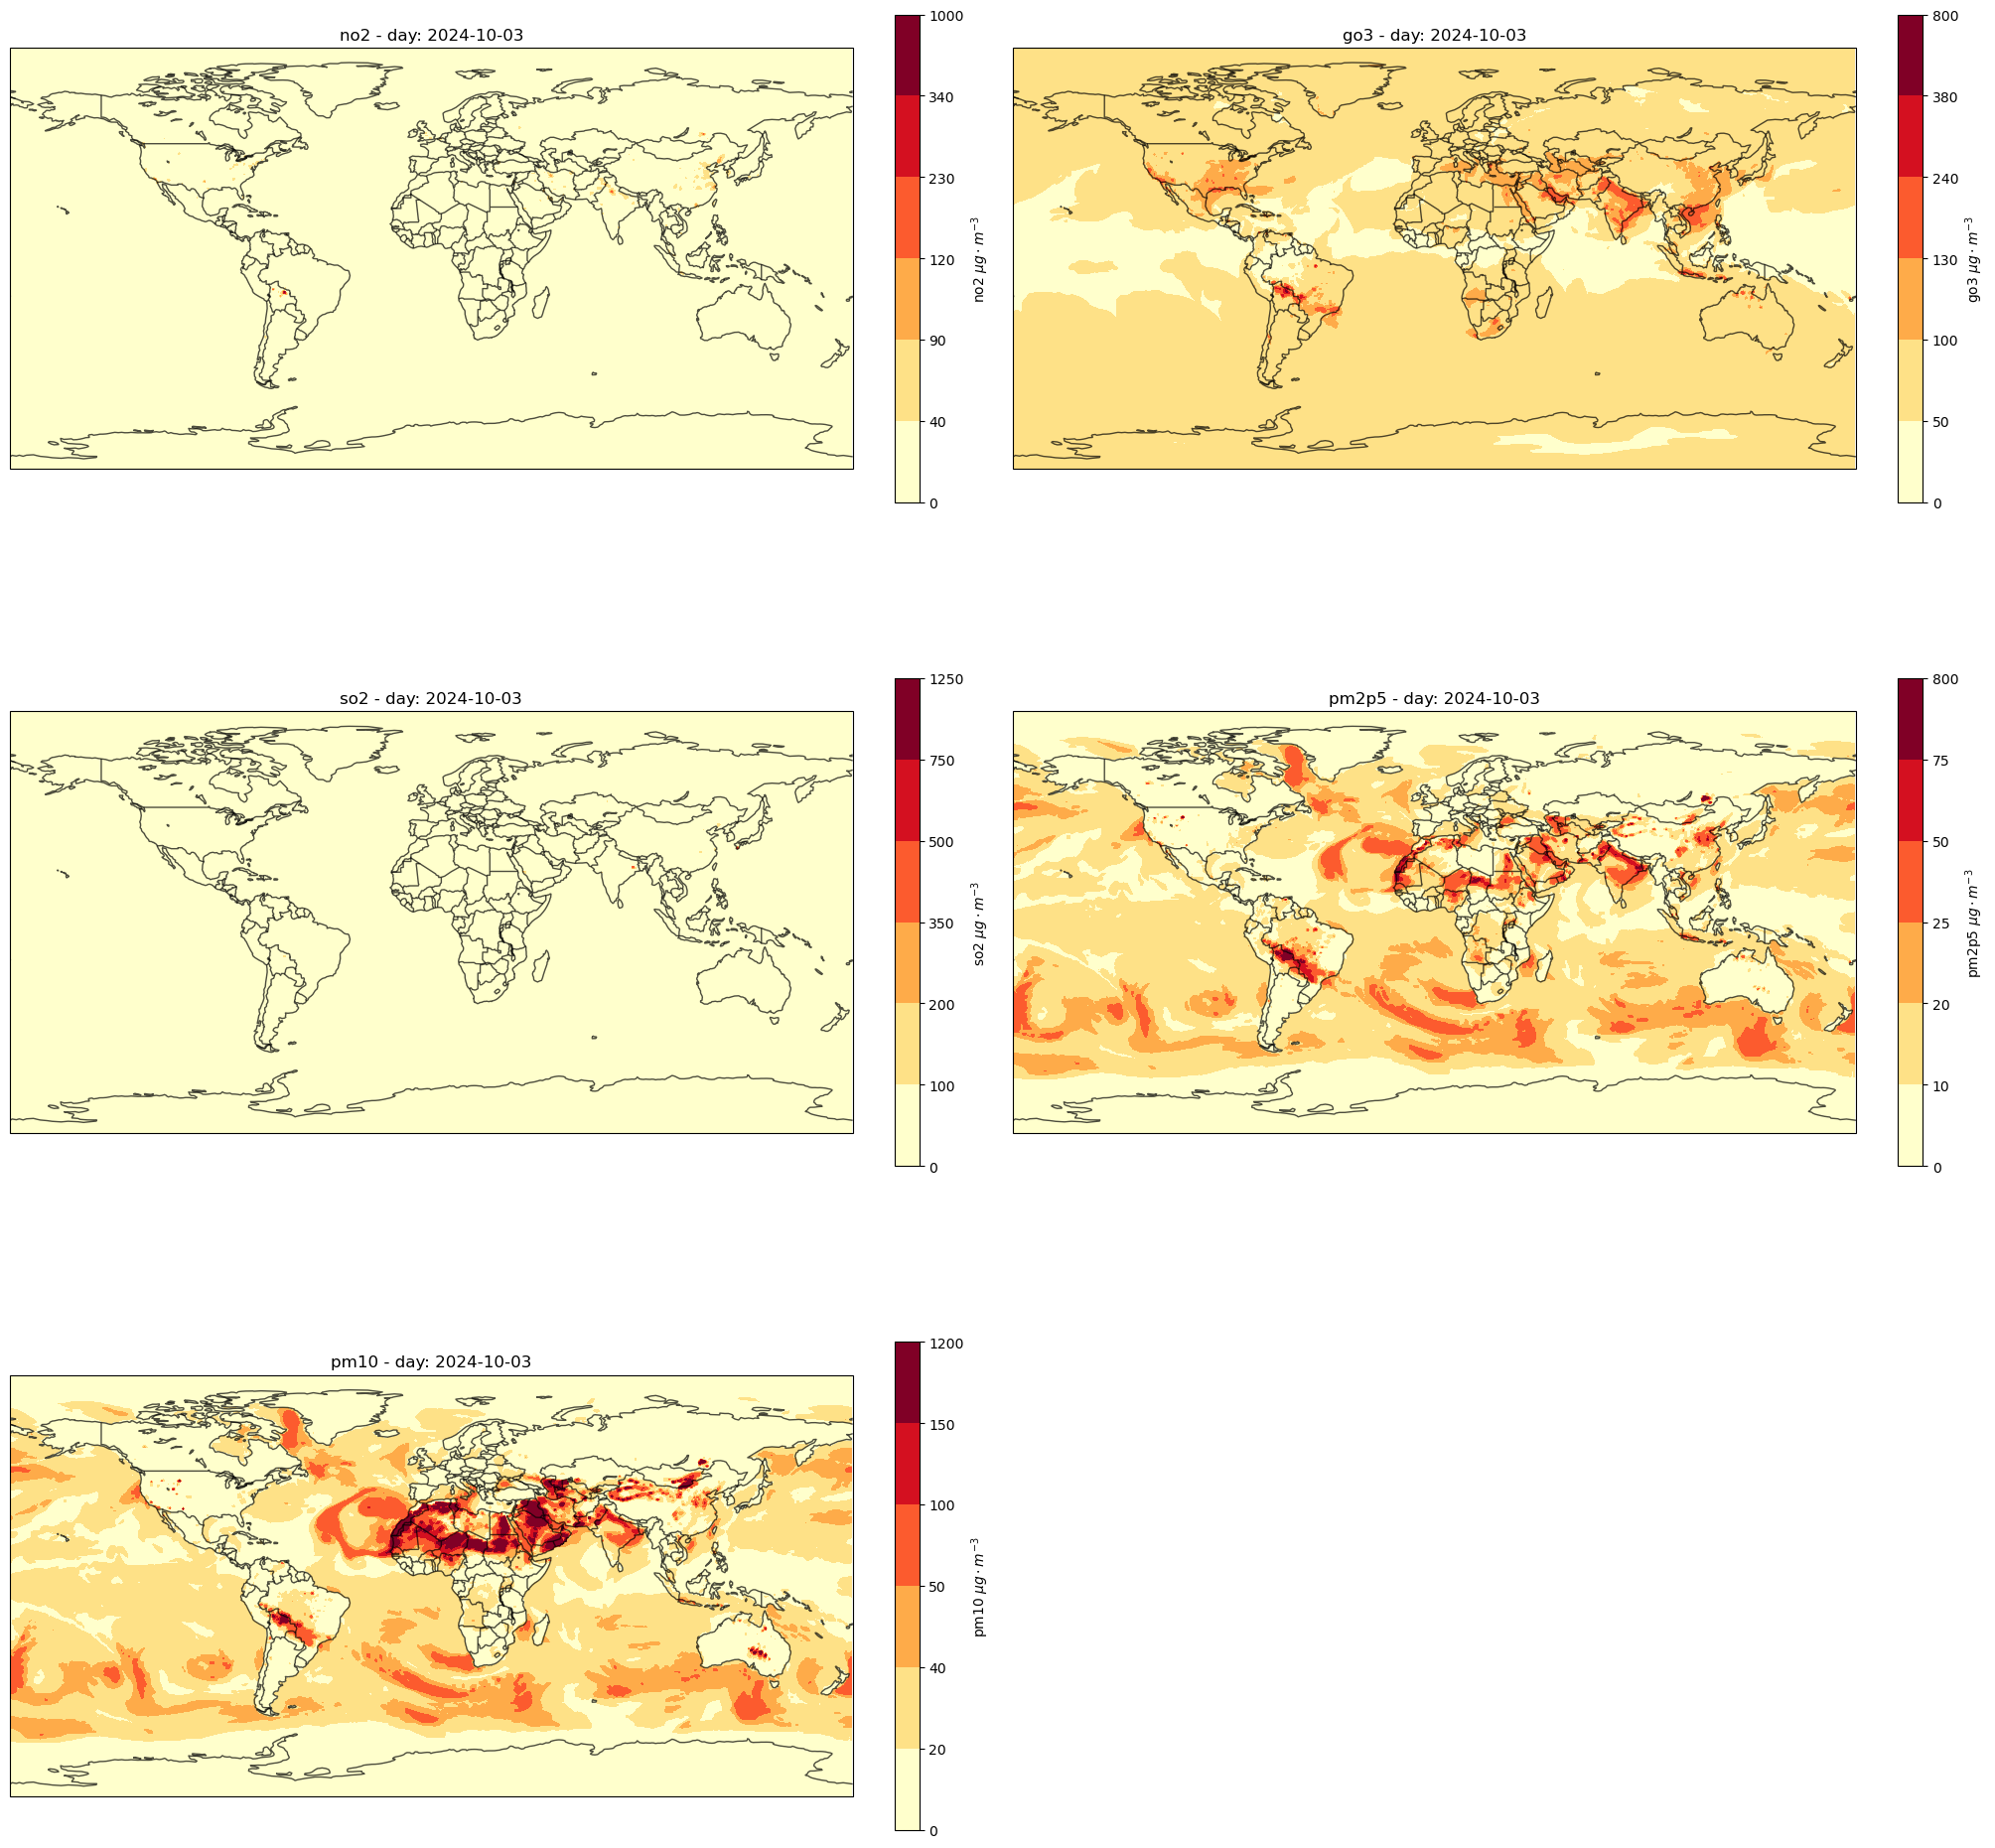

In [31]:
day_index = 0 # index of the daily forecasts, from 0 to 3
fig, axs = plt.subplots(nrows=3, ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20, 20), layout='constrained') 
axs = axs.flatten()
days = [str(day)[:10] for day in eaqi_daily.valid_time.to_numpy()]
fig.delaxes(axs[5])
for i, param in enumerate(params):
    da = eaqi_daily[param]
    clevs = all_levels[i]
    day = days[day_index]
    data = da[day_index,:,:] 
    cs = axs[i].contourf(da.longitude, da.latitude, data, 
                        levels = clevs, 
                        cmap='YlOrRd', # 'RdYlBu_r', 
                        norm = mcol.BoundaryNorm(clevs, 256), 
                        transform=ccrs.PlateCarree())

    cbar = plt.colorbar(cs, fraction=0.046, pad=0.05, orientation='vertical', shrink=0.75, ticks=clevs)
    cbar.set_label(param + ' $\mu g \cdot m^{-3}$')
    #axs[i].set_yticklabels(clevs)
    axs[i].set_extent([bb_west, bb_east, bb_south, bb_north], crs=ccrs.PlateCarree()) 
    axs[i].set_title(param + ' - day: ' + day)
    axs[i].coastlines(color='black', alpha=0.7) 
    axs[i].add_feature(cfeature.LAKES, alpha=0.7, edgecolor='black', facecolor='none')
    axs[i].add_feature(cfeature.BORDERS, alpha=0.7)
    axs[i].margins(0.1)

## Calculating the air quality index
With the concentration of the five polluttants we can calculate the air quality index. The air quality index of a pollutant X can be calculated using the equation

$$I_x = \frac{I_{high} - I_{low}}{C_{high} - C_{low}}(C_x - C_{low}) + I_{low}$$

where $I_{high}$ is the right AQI index value of the interval that contains the concentration value $C_x$, $I_{low}$ is the left AQI index value, and $C_{low}$ and $C_{high}$ are the concentration thresholds of that interval.


|$NO_2$ $(\mu g/m^3)$|$O_3$ $(\mu g/m^3)$|$SO_2$ $(\mu g/m^3)$|$PM2.5$ $(\mu g/m^3)$|$PM10$ $(\mu g/m^3)$| AQI|Category|
|---------|--------|------|-----------|------------|--------|-------|
| 0-40 | 0-50 | 0-100| 0-10 | 0-20|1|Good|
| 40-90 | 50-100 | 100-200 | 10-20 | 20-40 | 2|Fair|
| 90-120 | 100-130 | 200-350 | 20-25 | 40-50 | 3|Moderate|
| 120-230 | 130-240 | 350-500 | 25-50 | 50-100 | 4|Poor|
| 230-340 | 240-380 | 500-750 | 50-75 | 100-150 | 5|Very Poor|
| 340-1000 | 380-800 | 750-1250 | 75-800 | 150-1200 | 6|Extremely Poor|

We use the same intervals defined for the European Air Quality Index to compute the value of the index from the concentration values of the pollutant

In [34]:
bin_list = all_levels

We define a function to map the concentration values to one of the intervals that have been defined for the air quality index

In [35]:
def classify_forecast_variables(forecast_ds):
    '''
    This function assigns an integer value according to a class 
    for each float value in the dataset.
    '''
    classified_arrays = []
    for i in range(0, len(forecast_ds)):
        variable = params[i]
        temp = xr.apply_ufunc(np.digitize,
                              forecast_ds[variable],
                              bin_list[i])
        classified_arrays.append(temp)
        combined_arrays = xr.merge(classified_arrays)
        final_index = combined_arrays.to_array().max('variable')
    return final_index

In [36]:
aqi_index = classify_forecast_variables(eaqi_daily)

We define a colormap for the AQI according to the [EEA colourscale](https://airindex.eea.europa.eu/AQI/index.html)

In [37]:
good_color = '#03fcf0'
fair_color = '#16d984'
moderate_color = '#dffa11'
poor_color = '#db4918'
very_poor_color = '#873c23'
extremely_poor_color = '#5a2387'
colors = [good_color, fair_color, moderate_color, poor_color, very_poor_color, extremely_poor_color]
labels = ['Good', 'Fair', 'Moderate', 'Poor', 'Very Poor', 'Extremely Poor']
levels = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
level_ticks = [1, 2, 3, 4, 5, 6]
aqi_cmap = ListedColormap(colors)

## Global AQI map

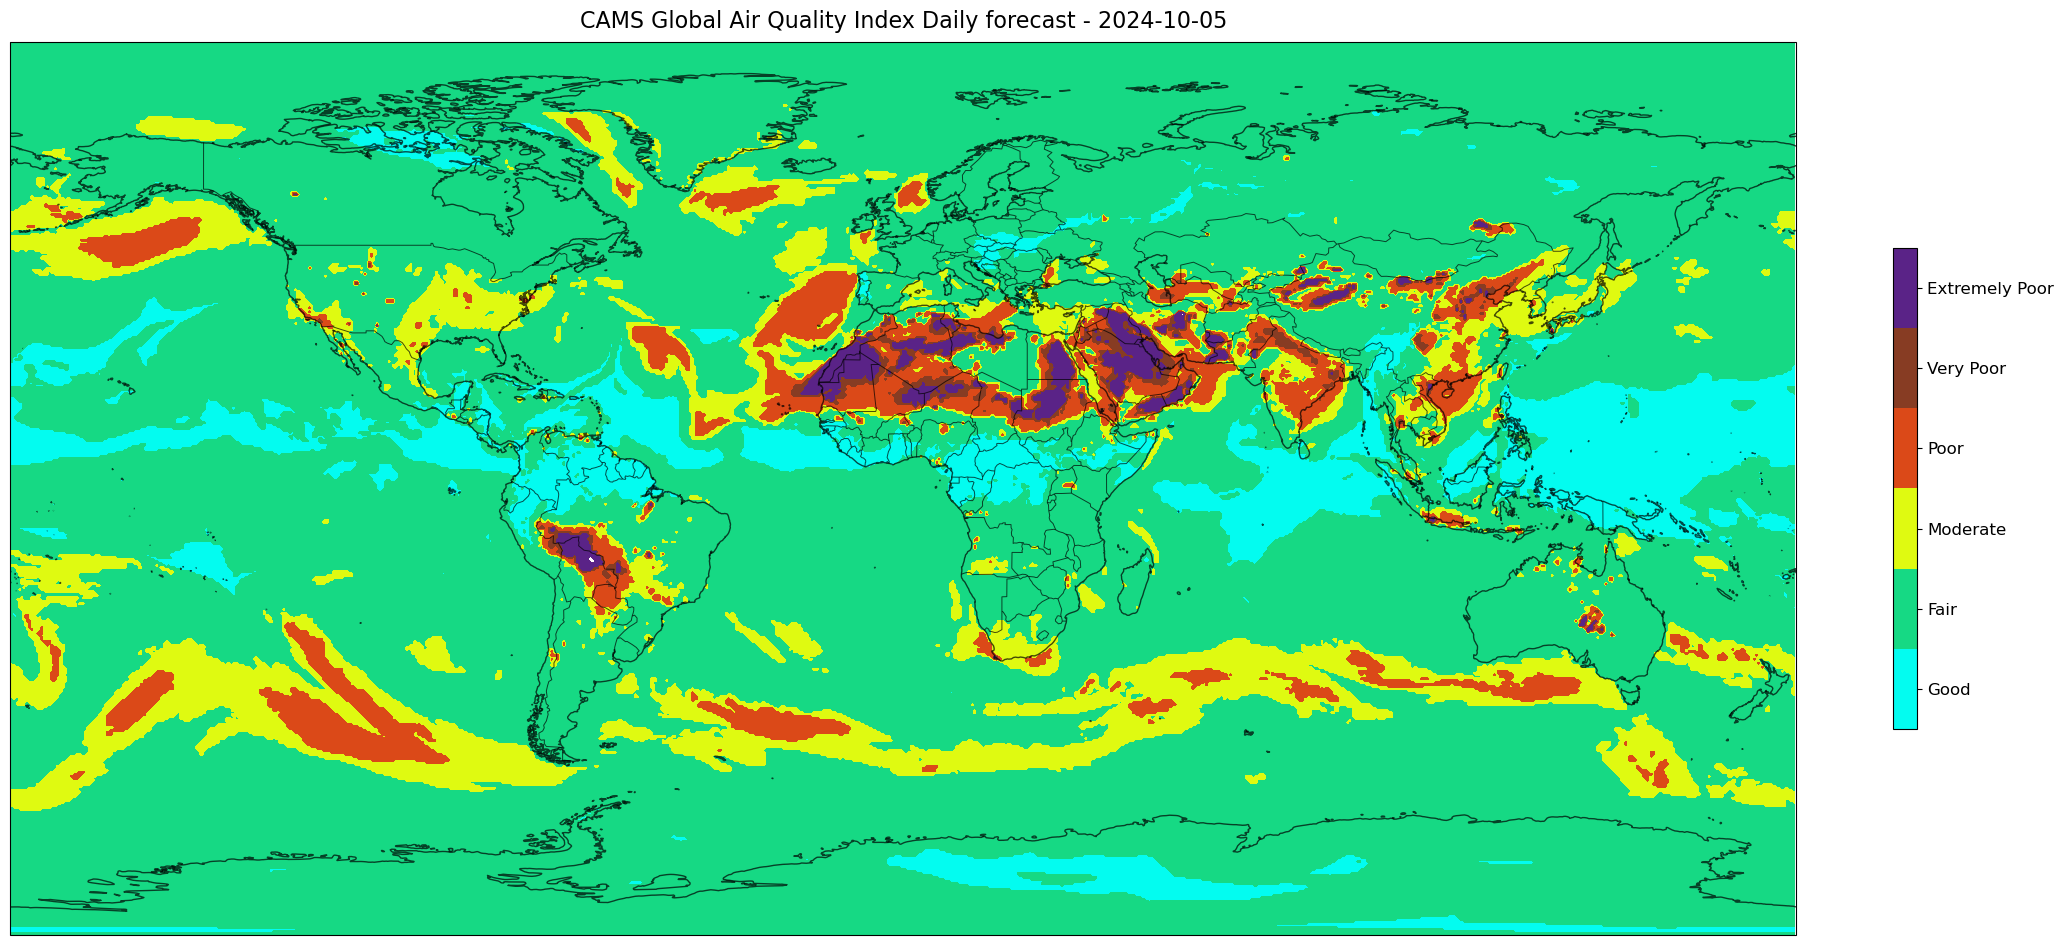

In [38]:
day = '2024-10-05'
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(25, 25))
timestamp = aqi_index.valid_time
data = aqi_index.sel(valid_time=day)
cs=ax.contourf(aqi_index.longitude, 
                       aqi_index.latitude, 
                       data,
                       levels=levels, 
                       cmap=aqi_cmap,
                       transform=ccrs.PlateCarree())
    
ax.set_title('CAMS Global Air Quality Index Daily forecast - ' + day, fontsize=16, pad=10.0)
ax.coastlines(color='black', alpha=0.7, resolution='50m')
ax.add_feature(cfeature.BORDERS, alpha=0.7, linewidth=0.7)
ax.set_extent([bb_west, bb_east, bb_south, bb_north], crs=ccrs.PlateCarree())
    
# Customize colorbar
cbar = plt.colorbar(cs, fraction=0.028, pad=0.05, shrink=0.25) 
cbar.set_label(None)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(level_ticks)
cbar.set_ticklabels(labels)

## Air quality heatmap for Kjeller
We can plot the air quality forecast of the polluttants as heatmap for any location by using its latitude and longitude. In this example we will plot the air quality forecast heatmap for Kjeller, a village east of Oslo, Norway. We will map the concentration of the polluttants in Kjeller to the classes defined for the air quality calculation. This step is similar to what was done before for the global map. After the ma

In [27]:
kjeller_lat = 59.9742
kjeller_lon = 11.0469

In [28]:
kjeller_day = eaqi_daily.sel(latitude = kjeller_lat, longitude = kjeller_lon, method='nearest')

In [29]:
days = [str(day)[:10] for day in kjeller_day.valid_time.to_numpy()]
days_index = pd.to_datetime(days)
days_index

DatetimeIndex(['2024-10-03', '2024-10-04', '2024-10-05', '2024-10-06'], dtype='datetime64[ns]', freq=None)

In [30]:
def classify_forecast(forecast_ds, bin_list):
    '''
    This function assigns an integer value according to a class 
    in the bin_list to each float value in the input dataset.
    The function returns a Pandas series.
    '''
    classified_arrays = []
    temp = xr.apply_ufunc(np.digitize,
                          forecast_ds,
                          bin_list)
    classified_arrays.append(temp)
    combined_arrays = xr.merge(classified_arrays)
    aqi_index = combined_arrays.to_array().max('variable')
    aqi_ds = aqi_index.to_series()
    return aqi_ds.values

In [31]:
kjeller_no2 = classify_forecast(kjeller_day['no2'], no2_limits)
kjeller_o3 = classify_forecast(kjeller_day['go3'], o3_limits)
kjeller_so2 = classify_forecast(kjeller_day['so2'], so2_limits)
kjeller_pm25 = classify_forecast(kjeller_day['pm2p5'], pm25_limits)
kjeller_pm10 = classify_forecast(kjeller_day['pm10'], pm10_limits)

In [32]:
kjeller_dict = {'pm10': kjeller_pm10,
                'pm25': kjeller_pm25,
                'so2': kjeller_so2,
                'o3': kjeller_o3,
                'no2': kjeller_no2}

In [33]:
kjeller_df = pd.DataFrame(kjeller_dict, index=days_index)
kjeller_df

,pm10,pm25,so2,o3,no2
2024-10-03,1,1,1,2,1
2024-10-04,1,2,1,2,1
2024-10-05,1,1,1,2,1
2024-10-06,1,1,1,2,1


In [34]:
kjeller_df = (kjeller_df.T).iloc[::-1]
kjeller_df

,2024-10-03,2024-10-04,2024-10-05,2024-10-06
no2,1,1,1,1
o3,2,2,2,2
so2,1,1,1,1
pm25,1,2,1,1
pm10,1,1,1,1


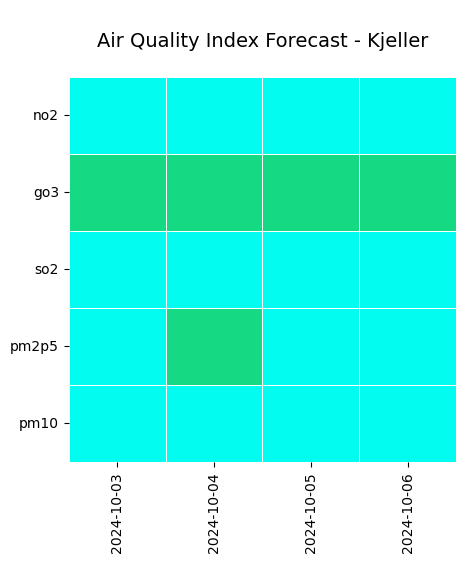

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#cbar_ax = fig.add_axes([.82, .13, .01, .75])
#fig.tight_layout()
g = sns.heatmap(kjeller_df, 
                cmap=aqi_cmap, 
                linewidth = 0.5, 
                linecolor = 'w', 
                ax=ax,
                #cbar_ax = cbar_ax, 
                vmin = 1, 
                vmax = 6, cbar=False)

g.set_title("\nAir Quality Index Forecast - Kjeller\n", fontsize=14)
#g.set(xlabel=None)

g.set_yticklabels(params, fontsize=10, rotation=0)

xlabels = kjeller_df.columns.format('%Y-%m-%d')[1::]
g.set_xticklabels(xlabels, fontsize=10);

# Customize colorbar entries
#cbar = ax.collections[0].colorbar  
#cbar.set_ticks([1.4,2.2,3.1,3.9,4.8,5.6])
#cbar.set_ticklabels(labels)
#cbar.ax.tick_params(labelsize=11)

## References
* [Jacob - Introduction to Atmospheric Chemistry](https://acmg.seas.harvard.edu/education/introduction-atmospheric-chemistry)
* Wilks - Statistical Methods in Atmospheric Science, 2nd Edition

## Appendix - Scaling factor
We start from the definition of mass mixing ratio of a chemical species X in air

$$\alpha_x = \frac{\rho_x}{\rho}$$

where $\rho_x$ is the mass density of the chemical species X in $kgm^{-3}$ and $\rho$ is the mass density of the air. We assume the trace gases and the dry air to follow the ideal gas law so that for dry air we can write

$$pV = nRT$$

where p is the air pressure, $R = K_B N_A = 8.314 \text{ } JK^{-1}mol^{-1}$ is the ideal gas constant, where $K_B$ is the Boltzmann constant and $N_A$ is the Avogadro's number, V the volume, T the temperature, and finally n is the number of moles. The number of moles is defined as the ratio of the mass and the molar mass. For dry air, a mixture of several gases, the molar mass $M_a$ can be represented by the weighted sum of the molar masses of all the chemical species in the air (see Jacob, chap.1, p.4)

$$M_a = \sum_i w_iM_i = 28.96 \cdot 10^{-3} \text{ } kg\text{ }mol^{-1}$$

With this defnition the number of moles of dry air can be written as

$$n = \frac{m}{M_a}$$
 
where m is the mass of the dry air. Substituting this definition into the gas law for dry air we have

$$pV = \frac{m}{M_a}RT$$

We can define the gas constant of dry air from the ideal gas constant R and the molar mass of dry air

$$R_a = \frac{R}{M_a} = \frac{8.314 \text{ } JK^{-1}mol^{-1}}{28.96 \cdot 10^{-3} \text{ } kg\text{ }mol^{-1}} = 287.08 \text{ } JK^{-1}kg^{-1}$$

We can now write the law for dry air as

$$pV = mR_aT$$

and

$$p = \frac{m}{V}R_aT = \rho R_aT$$

so that the mass density of dry air is

$$\rho = \frac{p}{R_aT}$$

from which we can write the equation of the mass density of a chemical species in the air as a function of its mixing ratio, the air pressure and temperature, and given the air specific gas constant

$$\rho_x = \alpha_x \frac{p}{R_aT} \text{ } kg m^{-3}$$

If we define the factor c as

$$c = \frac{p}{R_aT}$$

we can transform the mixing ratio of a chemical species to mass density using the equation

$$\rho_x = c \alpha_x$$